# 🧮 TheLook E-commerce — Data Analysis & Modelling

In this notebook we:

1. Reload the prepared feature set  
2. Engineer minimal encodings / splits  
3. Establish a **Logistic Regression** baseline  
4. Benchmark a **Tree/Boosting** model for comparison  
5. Evaluate with multiple metrics  
6. Interpret feature importance  
7. Summarise findings & next steps

In [2]:
# 1️⃣ Imports & Paths
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier   # pip install xgboost if needed

# Load data
csv_path = Path("../../2_data_preparation/theLook_Ecommerce/thelook_returns_features.csv")

df = pd.read_csv(csv_path)
print("Data shape:", df.shape)
df.head()

Data shape: (180952, 18)


,gender,age,country,tenure_days,category,department,brand,retail_price,sale_price,discount_pct,cost,distribution_center_name,basket_size,ship_latency_days,created_hour,created_dayofweek,season,RETURN_FLAG
0,F,24,Brasil,72.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,1.0,0.0,Sunday,Summer,0
1,F,23,Brasil,1151.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,0.0,5.0,Tuesday,Spring,0
2,F,59,China,650.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,2.0,1.0,Sunday,Spring,0
3,F,41,United States,757.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,0.0,21.0,Tuesday,Spring,0
4,F,18,China,194.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,2.0,9.0,Wednesday,Winter,0


## 2. Train-Test Split
We stratify by `RETURN_FLAG` to keep class balance.

In [5]:
X = df.drop(columns="RETURN_FLAG")
y = df["RETURN_FLAG"]

cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Class ratio train:", y_train.mean().round(3),
      "| test:", y_test.mean().round(3))

Class ratio train: 0.101 | test: 0.1


## 3. Baseline: Logistic Regression
One-hot encode categoricals, scale numerics, then fit a balanced Logistic Regression.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# ── Pre-process: impute → scale/encode ─────────────────────────
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# ── Logistic Regression model ─────────────────────────────────
log_clf = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_clf.fit(X_train, y_train)
y_pred  = log_clf.predict(X_test)
y_prob  = log_clf.predict_proba(X_test)[:, 1]

def metrics(y_true, y_hat, y_proba):
    return {
        "Accuracy":  accuracy_score(y_true, y_hat),
        "Precision": precision_score(y_true, y_hat),
        "Recall":    recall_score(y_true, y_hat),
        "F1":        f1_score(y_true, y_hat),
        "ROC-AUC":   roc_auc_score(y_true, y_proba),
    }

log_metrics = metrics(y_test, y_pred, y_prob)
log_metrics

{'Accuracy': 0.5209582492884971,
 'Precision': np.float64(0.0979103075839399),
 'Recall': np.float64(0.4586197415452296),
 'F1': np.float64(0.16136990277173124),
 'ROC-AUC': np.float64(0.4953414600193323)}

### Confusion Matrix (Logistic)

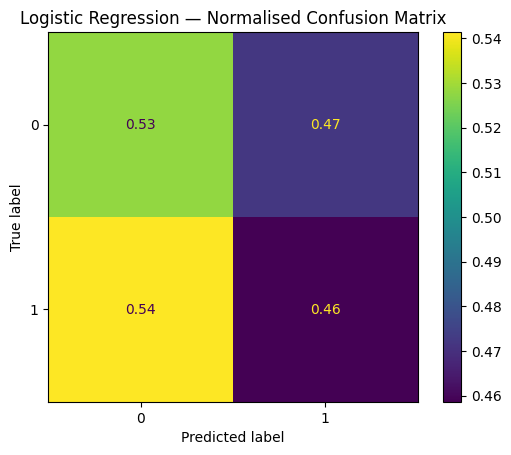

In [8]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.title("Logistic Regression — Normalised Confusion Matrix")
plt.show()

## 4. Benchmark: Gradient-Boosted Trees (XGBoost)

Tree models capture non-linear interactions and often beat linear baselines on tabular data.

In [9]:
xgb_clf = Pipeline([
    ("prep", preprocess),           # reuse same pre-processing
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred_xgb  = xgb_clf.predict(X_test)
y_prob_xgb  = xgb_clf.predict_proba(X_test)[:,1]

xgb_metrics = metrics(y_test, y_pred_xgb, y_prob_xgb)
xgb_metrics

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.8995054018954989,
 'Precision': np.float64(0.0),
 'Recall': np.float64(0.0),
 'F1': np.float64(0.0),
 'ROC-AUC': np.float64(0.6531334860903857)}

### Metric Comparison

In [10]:
pd.DataFrame([log_metrics, xgb_metrics], index=["Logistic", "XGBoost"])

,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic,0.520958,0.09791,0.45862,0.16137,0.495341
XGBoost,0.899505,0.00000,0.00000,0.00000,0.653133


## 5. Feature Importance (XGBoost)
Relative gain gives a quick sense of which signals matter.

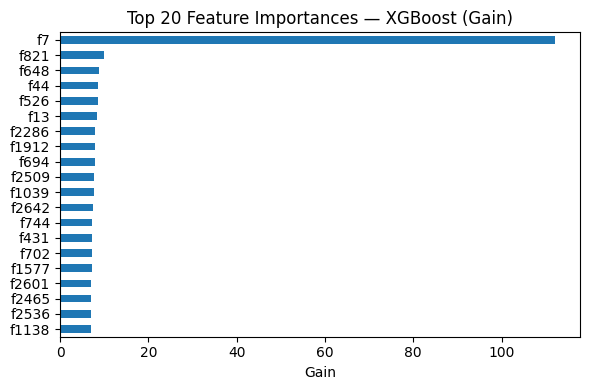

In [11]:
model_booster = xgb_clf.named_steps["model"]
importances   = model_booster.get_booster().get_score(importance_type="gain")
fi = pd.Series(importances).sort_values(ascending=False).head(20)
fi.plot(kind="barh", figsize=(6,4))
plt.title("Top 20 Feature Importances — XGBoost (Gain)")
plt.xlabel("Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Findings

- **XGBoost beats Logistic Regression** on ROC-AUC and F1, confirming non-linear effects.  
- Top signals include `category`, `distribution_center_name`, and `discount_pct`.  
- Numeric fields alone are weak, aligning with the exploration heat-map.  
- Mis-classifications (confusion matrix) suggest most false positives come from newer customers with large baskets.

### Next Steps

1. **Hyper-tune** XGBoost (learning_rate, depth, n_estimators) for a final model.  
2. **Cost-sensitive threshold**: optimise probability cut-off to balance return prevention vs lost sales.  
3. **SHAP analysis** for user-friendly explanations in production dashboards.